<a href="https://colab.research.google.com/github/sellerstx1982/multimodal_damage_identification/blob/Irfan/project_3_(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from pathlib import Path
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score, classification_report
from PIL import Image, ImageFile
import os
import matplotlib.pyplot as plt
import zipfile

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
# Preprocessing function for images
def preprocess_image(image_path):
    try:
        image = Image.open(image_path)
        image = image.resize((250, 250))  # Example size, adjust accordingly
        image = np.array(image) / 255.0  # Normalize pixel values
        return np.expand_dims(image, axis=0)  # Add batch dimension (1, 250, 250, 3)
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None
folder = '/content/drive/MyDrive/Sample Pictures'
images = []
# Get and sort image files
image_files = sorted([file for file in os.listdir(folder) if file.endswith(('jpg', 'jpeg', 'png'))])
# Process each image
for image_file in image_files:
    image_path = os.path.join(folder, image_file)
    processed_image = preprocess_image(image_path)
    if processed_image is not None:
        images.append(processed_image)

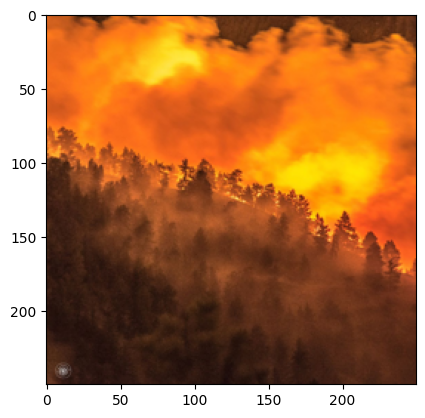

In [4]:
#Display photo
images[0].shape
import matplotlib.pyplot as plt
plt.imshow((images[19][0] * 255).astype('uint8'))

In [5]:
data = pd.DataFrame({'image': images})
data.head()

,image
0,"[[[[0.37254902 0.38039216 0.36862745], [0.3725..."
1,"[[[[0.10588235 0.10980392 0.1254902 ], [0.1058..."
2,"[[[[0.5254902 0.47843137 0.34509804], [0.4745..."
3,"[[[[0.75294118 0.9254902 0.99215686], [0.7686..."
4,"[[[[0.18823529 0.15686275 0.07058824], [0.2235..."


In [6]:
# Create a mapping dictionary for the indices
index_to_label = {
    0: 'flood',
    1: 'human',
    2: 'human',
    3: 'human',
    4: 'human',
    5: 'building collapse',
    6: 'building collapse',
    7: 'building collapse',
    8: 'fire',
    9: 'fire',
    10: 'building collapse',
    11: 'flood',
    12: 'drought',
    13: 'drought',
    14: 'drought',
    15: 'drought',
    16: 'flood',
    17: 'flood',
    18: 'fire',
    19: 'fire'
}
# Map the index to the corresponding label
data['label'] = [index_to_label[i] for i in range(len(data))] # Display the first few rows of the DataFrame to check the resultprint(data.head())


In [7]:
import pickle
#Load the data from pkl files
def load_data_from_pkl(pkl_filename):
    with open(pkl_filename, 'rb') as f:
        sample_df = pickle.load(f)
    return sample_df

df = load_data_from_pkl('/content/drive/MyDrive/disaster_data.pkl')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 4436 to 4841
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    1000 non-null   object
 1   text     1000 non-null   object
 2   label    1000 non-null   object
 3   label_2  1000 non-null   object
 4   label_3  1000 non-null   object
dtypes: object(5)
memory usage: 46.9+ KB


# Preprocessing

In [ ]:
# ImageFile.LOAD_TRUNCATED_IMAGES = True
# main_folder = "/content/drive/MyDrive/multimodal+damage+identification+for+humanitarian+computing/multimodal/"

In [ ]:
# # Lists to store the data
# images = []
# texts = []
# labels = []

# # Preprocessing function for images
# def preprocess_image(image_path):
#     try:
#         image = Image.open(image_path)
#         image = image.resize((250, 250))  # Example size, adjust accordingly
#         image = np.array(image) / 255.0  # Normalize pixel values
#         return np.expand_dims(image, axis=0)  # Add batch dimension
#     except Exception as e:
#         print(f"Error processing image {image_path}: {e}")
#         return None

# # Function to load text from a file
# def load_text_file(text_path):
#     try:
#         with open(text_path, 'r', encoding='utf-8') as file:
#             return file.read()
#     except Exception as e:
#         print(f"Error reading text file {text_path}: {e}")
#         return None

In [ ]:
# # Iterate over each category subfolder in the main folder
# for subfolder in os.listdir(main_folder):
#     subfolder_path = os.path.join(main_folder, subfolder)
#     if os.path.isdir(subfolder_path):
#         # The image and text folders inside each category folder
#         image_folder = os.path.join(subfolder_path, 'images')
#         text_folder = os.path.join(subfolder_path, 'text')

#         # Check if both the image and text folders exist
#         if os.path.exists(image_folder) and os.path.exists(text_folder):
#             for image_file in os.listdir(image_folder):
#                 if image_file.endswith(('jpg', 'jpeg', 'png')):
#                     image_path = os.path.join(image_folder, image_file)
#                     # Construct the corresponding text file name
#                     text_file = image_file.rsplit('.', 1)[0] + '.txt'
#                     text_path = os.path.join(text_folder, text_file)

#                     # Check if the text file exists and load both image and text
#                     if os.path.exists(text_path):
#                         image = preprocess_image(image_path)
#                         if image is not None:
#                             text = load_text_file(text_path)
#                             if text is not None:
#                                 # Extract the label by splitting at the underscore and taking the first part
#                                 label = image_file.split('_', 1)[0]
#                                 images.append(image)
#                                 texts.append(text)
#                                 labels.append(label)  # Append the prefix before the first underscore as label


In [ ]:
# # images = np.array([np.array(image) for image in images])
# type(images)

list

In [ ]:
# print(len(images))
# print(len(texts))
# print(len(labels))

5831
5831
5831


In [ ]:
# df = pd.DataFrame({'image': images, 'text': texts, 'label': labels})
# df.head()

,image,text,label
0,"[[[[0.82352941 0.90588235 0.97254902], [0.8235...",#isiscrimes \nIsis dogs crucified a men accuse...,isiscrimes
1,"[[[[0.99607843 0.99607843 0.99607843], [0.9960...",Part 2:\n\nIn January of this year Abu Rayyan ...,isiscrimes
2,"[[[[0.99607843 0.99607843 0.99607843], [0.9960...",Wake up.ppl see the reality to what ISIS is al...,isiscrimes
3,"[[[[0.58823529 0.44705882 0.34509804], [0.5803...",New image from akhtarin in aleppo #Syria yeste...,isiscrimes
4,"[[[[0.4627451 0.38039216 0.2745098 ], [0.4627...",Syria #Aleppo ISIS continue on with their behe...,isiscrimes


In [ ]:
# df['label_2'] = df['label'].replace({'destruction': 'destruction',
#                                    'drought': 'drought',
#                                    'buildingcollapse': 'earthquake',
#                                    'destroyedbuilding': 'earthquake',
#                                    'earthquake': 'earthquake',
#                                    'earthquakenepal': 'earthquake',
#                                    'buildingfire': 'fire',
#                                    'forestfire': 'fire',
#                                    'forrestfire': 'fire',
#                                    'wildfires': 'fire',
#                                    'accrafloods': 'flood',
#                                    'floodwater': 'flood',
#                                    'hurricaneharvey': 'hurricane',
#                                    'hurricaneirma': 'hurricane',
#                                    'hurricanematthew': 'hurricane',
#                                    'hurricanesandy': 'hurricane',
#                                    'sandydamage': 'hurricane',
#                                    'treefalling': 'hurricane',
#                                    'treesfalling': 'hurricane',
#                                    'windstorm': 'hurricane',
#                                    'landslide': 'landslide',
#                                    'disaster': 'naturaldisaster',
#                                    'disasters': 'naturaldisaster',
#                                    'naturaldamage': 'naturaldisaster',
#                                    'naturaldisaster': 'naturaldisaster',
#                                    'ad': 'non-damage',
#                                    'building': 'non-damage',
#                                    'cars': 'non-damage',
#                                    'food': 'non-damage',
#                                    'nature': 'non-damage',
#                                    'terrorattack': 'war',
#                                    'isiscrimes': 'war',
#                                    'yemencrisis': 'war',
#                                    'suicidebombing': 'war',
#                                    'victimsofwar': 'war',
#                                    'war': 'war',
#                                    'syriawarcrimes': 'war',
#                                    'warsyria': 'war',
#                                    'yemencrisis': 'war',
#                                    'wreckedcar': 'wreckedcar',
#                                    })

In [ ]:
# df['label_3'] = df['label'].replace({'destruction': 'damage',
#                                    'drought': 'damage',
#                                    'buildingcollapse': 'damage',
#                                    'destroyedbuilding': 'damage',
#                                    'earthquake': 'damage',
#                                    'earthquakenepal': 'damage',
#                                    'buildingfire': 'damage',
#                                    'forestfire': 'damage',
#                                    'forrestfire': 'damage',
#                                    'wildfires': 'damage',
#                                    'accrafloods': 'damage',
#                                    'floodwater': 'damage',
#                                    'hurricaneharvey': 'damage',
#                                    'hurricaneirma': 'damage',
#                                    'hurricanematthew': 'damage',
#                                    'hurricanesandy': 'damage',
#                                    'sandydamage': 'damage',
#                                    'treefalling': 'damage',
#                                    'treesfalling': 'damage',
#                                    'windstorm': 'damage',
#                                    'landslide': 'damage',
#                                    'disaster': 'damage',
#                                    'disasters': 'damage',
#                                    'naturaldamage': 'damage',
#                                    'naturaldisaster': 'damage',
#                                    'ad': 'non-damage',
#                                    'building': 'non-damage',
#                                    'cars': 'non-damage',
#                                    'food': 'non-damage',
#                                    'nature': 'non-damage',
#                                    'terrorattack': 'damage',
#                                    'isiscrimes': 'damage',
#                                    'yemencrisis': 'damage',
#                                    'suicidebombing': 'damage',
#                                    'victimsofwar': 'damage',
#                                    'war': 'damage',
#                                    'syriawarcrimes': 'damage',
#                                    'warsyria': 'damage',
#                                    'yemencrisis': 'damage',
#                                    'wreckedcar': 'damage',

#                                    })

In [ ]:
df.head()

,image,text,label,label_2,label_3
4436,"[[[[0.48235294 0.6627451 0.90588235], [0.4823...",It's always the moment to install solar contro...,building,non-damage,non-damage
5297,"[[[[1. 1. 1.], [1. 1. 1.], [1. 1. 1.], [1. 1. ...",Esmond lake \n@motobudz91 \n#lake #log #oregon...,landslide,landslide,damage
1121,"[[[[0.6745098 0.70980392 0.83529412], [0.6745...",Goodbye suit corner. #buildingcollapse #accide...,buildingcollapse,earthquake,damage
561,"[[[[0.88627451 0.8745098 0.83921569], [0.5725...",#somalia is a country that the world does not ...,terrorattack,war,damage
1188,"[[[[0.71372549 0.70196078 0.76862745], [0.7137...",NJ State Troopers patrolling The Streets of Un...,sandydamage,hurricane,damage


In [ ]:
df['label_3'].value_counts()

,count
label_3,
non-damage,513
damage,487


In [ ]:
# sample_df = df.sample(n=1000, random_state=42)
# sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 4436 to 4841
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    1000 non-null   object
 1   text     1000 non-null   object
 2   label    1000 non-null   object
 3   label_2  1000 non-null   object
 4   label_3  1000 non-null   object
dtypes: object(5)
memory usage: 46.9+ KB


In [ ]:
# sample_df['label_3'].value_counts()

,count
label_3,
non-damage,513
damage,487


In [ ]:
df.head()

,image,text,label,label_2,label_3
4436,"[[[[0.14509804 0.12941176 0.03137255], [0.1450...",#vulcan#vulcaninsel#instagram#instavulcan#volc...,earthquake,earthquake,damage
5297,"[[[[0.91372549 0.91372549 0.96078431], [0.9137...",Making the best of the flood waters this morni...,floodwater,flood,damage
1121,"[[[[0.98431373 0.98431373 0.98431373], [0.9843...",*كلام حلو* .\n.\n\n#streetworkout #streetstyle...,ad,non-damage,non-damage
561,"[[[[0.97647059 0.97647059 0.97647059], [0.9568...",do you like this😜😜\n#\n.\nvia @freschle\n.\n.\...,treefalling,hurricane,damage
1188,"[[[[0.04705882 0.0627451 0.10588235], [0.0392...",WhatsApp On +919466780004 #earrings #jhumki #c...,ad,non-damage,non-damage


#Label and Split Data

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 4436 to 4841
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    1000 non-null   object
 1   text     1000 non-null   object
 2   label    1000 non-null   object
 3   label_2  1000 non-null   object
 4   label_3  1000 non-null   object
dtypes: object(5)
memory usage: 46.9+ KB


In [10]:
df.head()

,image,text,label,label_2,label_3
4436,"[[[[0.48235294 0.6627451 0.90588235], [0.4823...",It's always the moment to install solar contro...,building,non-damage,non-damage
5297,"[[[[1. 1. 1.], [1. 1. 1.], [1. 1. 1.], [1. 1. ...",Esmond lake \n@motobudz91 \n#lake #log #oregon...,landslide,landslide,damage
1121,"[[[[0.6745098 0.70980392 0.83529412], [0.6745...",Goodbye suit corner. #buildingcollapse #accide...,buildingcollapse,earthquake,damage
561,"[[[[0.88627451 0.8745098 0.83921569], [0.5725...",#somalia is a country that the world does not ...,terrorattack,war,damage
1188,"[[[[0.71372549 0.70196078 0.76862745], [0.7137...",NJ State Troopers patrolling The Streets of Un...,sandydamage,hurricane,damage


In [11]:
X_image = df['image']
X_text = df['text']
y = df['label_3']

In [12]:
new_X_image = []
for row in X_image:
    for image in row:
        new_X_image.append(image)

new_X_image[0]

X_image = [np.array(img).astype(np.float32) for img in new_X_image]

In [13]:
resized_X_image = []

for img in X_image:
    if img.shape != (250, 250, 3):

        resized_img = np.resize(img, (250, 250, 3))

        resized_X_image.append(resized_img)
    else:

        resized_X_image.append(img)

X_image = np.array(resized_X_image)

In [14]:
print(X_image.shape)
print(X_image[0].shape)

(1000, 250, 250, 3)
(250, 250, 3)


In [15]:
y = y.replace({'damage': 1, 'non-damage': 0})

<ipython-input-15-29e6a47d55c9>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({'damage': 1, 'non-damage': 0})


In [16]:
X_train_image, X_test_image, X_train_text, X_test_text, y_train, y_test = train_test_split(X_image, X_text, y, test_size=0.2, random_state=42)


# Models

In [17]:
from tensorflow.keras.models import Sequential
# from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

# Add fully connected layers
model.add(Dense(64, activation='relu')) #changed leaky relu to relu
model.add(Dropout(0.5))  # Optional dropout for regularization

# model.add(Dense(64, activation='leaky_relu'))
# model.add(Dense(32, activation='leaky_relu'))

# Output layer
model.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' for binary classification
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 248, 248, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 122, 122, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 238144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      15,241,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,260,737 (58.22 MB)

 Trainable params: 15,260,737 (58.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# y_train = tf.keras.utils.to_categorical(y_train, num_classes=2) # Convert y_train to one-hot encoded format
# y_test = tf.keras.utils.to_categorical(y_test, num_classes=2) # Convert y_test as well for consistency


In [18]:
history = model.fit(X_train_image,
                    y_train,
                    epochs=10,
                    batch_size=64
                    )

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 430ms/step - accuracy: 0.5185 - loss: 2.1355
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.5411 - loss: 0.6868
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.6787 - loss: 0.6204
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.7653 - loss: 0.5352
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.8106 - loss: 0.4251
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.8779 - loss: 0.3148
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9216 - loss: 0.2207
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.9447 - loss: 0.1865
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.9629 - loss: 0.1312
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9708 - loss: 0.0785


In [19]:
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.6320 - loss: 1.0460


[1.1190061569213867, 0.6200000047683716]

In [20]:
predictions = model.predict(X_train_image)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [40]:
def create_cnn_model():
    base_model = tf.keras.applications.ResNet101(weights='imagenet', include_top=False, input_shape=(250, 250, 3))# using resnet 101 instead of 50
    base_model.trainable = False  # Freeze the pre-trained layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),  # Reduce the spatial dimensions
        layers.Dense(100, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    return model

cnn_model = create_cnn_model()

# # Extract features from images
# image_features = cnn_model.predict(images)

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [41]:
cnn_model.fit(X_train_image, y_train, epochs=10, batch_size=64)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 653ms/step - accuracy: 0.4795 - loss: 0.8724
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 350ms/step - accuracy: 0.4805 - loss: 0.7072
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 364ms/step - accuracy: 0.5722 - loss: 0.6850
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 370ms/step - accuracy: 0.5344 - loss: 0.6935
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 369ms/step - accuracy: 0.5363 - loss: 0.6846
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 383ms/step - accuracy: 0.5755 - loss: 0.6776
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 380ms/step - accuracy: 0.6136 - loss: 0.6634
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 377ms/step - accuracy: 0.6099 - loss: 0.6612
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 375ms/step - accuracy: 0.5659 - loss: 0.6751
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.6044 - loss: 0.6518


In [42]:
cnn_model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 762ms/step - accuracy: 0.5560 - loss: 0.6766


[0.667979896068573, 0.5849999785423279]

In [43]:
predictions = cnn_model.predict(X_train_image)

25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step


In [44]:
!pip install transformers

import tensorflow as tf
from transformers import GPT2Tokenizer, GPT2Model



 #Build the complete model

# CNN for image feature extraction
def create_cnn_model(input_shape):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the pre-trained layers

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Reduce dimensions
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    return base_model.input, x

image_input_shape = (250, 250, 3)
image_input, image_features = create_cnn_model(image_input_shape)

# # LSTM for text processing
# def create_lstm_model(vocab_size, embedding_dim, sequence_length):
#     text_input = tf.keras.Input(shape=(sequence_length,))
#     x = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=sequence_length)(text_input)
#     x = tf.keras.layers.LSTM(128)(x)
#     return text_input, x
# # Ensure tokenizer.word_index and max_sequence_length are defined before this point
# vocab_size = len(tokenizer.word_index) + 1
# embedding_dim = 128
# sequence_length = 100 #Replace with your actual sequence length

# text_input, text_features = create_lstm_model(vocab_size, embedding_dim, sequence_length)

# # Combine image features and text features
# combined_features = tf.keras.layers.Concatenate()([image_features, text_features])
# combined_output = tf.keras.layers.Dense(128, activation='relu')(combined_features)
# final_output = tf.keras.layers.Dense(1, activation='sigmoid')(combined_output)  # Binary classification

# # Build the complete model
# model = tf.keras.Model(inputs=[image_input, text_input], outputs=final_output)

# # Compile the model
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# # Model summary
# model.summary()

In [39]:
#Assuming `images` is a numpy array of image data
#Assuming `images` is a numpy array of image data
#Assuming `texts` is a list of raw text corresponding to the images

# Tokenize and pad the text data
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000)  # Adjust vocabulary size as needed
tokenizer.fit_on_texts('texts')
sequences = tokenizer.texts_to_sequences('texts')
max_sequence_length = 100  # Define max sequence length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# OR

# Using GPT-2 Tokenizer
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Add a padding token to the tokenizer
tokenizer.pad_token = tokenizer.eos_token

def tokenize_texts(texts):
    return tokenizer(texts, return_tensors='tf', padding=True, truncation=True, clean_up_tokenization_spaces=False)

# Tokenize the text data
tokenized_texts = tokenize_texts('texts')

# Example disaster reports (this could be loaded from your dataset)
sample_reports = ["Flood in Texas causes widespread damage.",
                  "Earthquake in Japan leads to massive destruction."]
tokenized_reports = tokenize_texts(sample_reports)

# Assuming `labels` is a numpy array containing the target labels for the task (e.g., 0 and 1 for binary classification)
import numpy as np
labels = np.array([0, 1])  # Replace with your actual labels


sequences = tokenizer.texts_to_sequences('texts')
max_sequence_length = 100  # Define max sequence length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

OR

# Using GPT-2 Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Add a padding token to the tokenizer
tokenizer.pad_token = tokenizer.eos_token

def tokenize_texts(texts):
    return tokenizer(texts, return_tensors='tf', padding=True, truncation=True, clean_up_tokenization_spaces=False)

# Tokenize the text data
tokenized_texts = tokenize_texts('texts')

# Example disaster reports (this could be loaded from your dataset)
sample_reports = ["Flood in Texas causes widespread damage.",
                  "Earthquake in Japan leads to massive destruction."]
tokenized_reports = tokenize_texts(sample_reports)

# Assuming `labels` is a numpy array containing the target labels for the task (e.g., 0 and 1 for binary classification)
labels = np.array([0, 1])  # Replace with your actual labels


Keyword arguments {'clean_up_tokenization_spaces': False} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': False} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': False} not recognized.


AttributeError: 'GPT2Tokenizer' object has no attribute 'texts_to_sequences'

In [33]:
# Split the data into training and test sets
# Pass all three arrays: images, padded_sequences, and labels
image_train, image_test, text_train, text_test, y_train, y_test = train_test_split(
    images, padded_sequences, labels, test_size=0.2, random_state=42)

print(f"Training set: {image_train.shape}, {text_train.shape}, {y_train.shape}")
print(f"Test set: {image_test.shape}, {text_test.shape}, {y_test.shape}")

NameError: name 'padded_sequences' is not defined

In [31]:
# Split the data into training and test sets
image_train, image_test, text_train, text_test, y_train, y_test = train_test_split(
    images, padded_sequences, labels, test_size=0.2, random_state=42)

print(f"Training set: {image_train.shape}, {text_train.shape}, {y_train.shape}")
print(f"Test set: {image_test.shape}, {text_test.shape}, {y_test.shape}")

ValueError: not enough values to unpack (expected 6, got 2)

In [ ]:
def create_lstm_model(image_feature_size, vocab_size, seq_length):
    image_input = layers.Input(shape=(image_feature_size,))
    text_input = layers.Input(shape=(seq_length,))

    # Combine Image and Text features
    x = layers.Concatenate()([image_input, text_input])
    x = layers.Embedding(vocab_size, 256)(x)
    x = layers.LSTM(256, return_sequences=True)(x)
    x = layers.Dense(vocab_size, activation='softmax')(x)

    model = models.Model(inputs=[image_input, text_input], outputs=x)
    return model

vocab_size = len(tokenizer)  # GPT tokenizer vocab size
seq_length = tokenized_reports['input_ids'].shape[1]  # Max sequence length
lstm_model = create_lstm_model(256, vocab_size, seq_length)

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
gpt2_model = TFGPT2LMHeadModel.from_pretrained('gpt2')

# Fine-tune GPT-2 model
def fine_tune_gpt2(image_features, texts, tokenizer):
    inputs = tokenizer(texts, return_tensors="tf", padding=True, truncation=True)
    outputs = gpt2_model(inputs['input_ids'], labels=inputs['input_ids'])
    loss = outputs.loss
    logits = outputs.logits

    # Train your model on this loss
    return loss

# Example training loop
for epoch in range(10):
    loss = fine_tune_gpt2(image_features, sample_reports, tokenizer)
    print(f"Epoch {epoch+1}, Loss: {loss}")


In [ ]:
# Save the CNN + LSTM model or GPT-2 based model
lstm_model.save("disaster_report_model.h5")

# For GPT-2 (Hugging Face)
gpt2_model.save_pretrained("disaster_gpt2_model")
tokenizer.save_pretrained("disaster_gpt2_model_tokenizer")


# Creating Web Application

In [ ]:
from flask import Flask, request, jsonify
import tensorflow as tf
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
from PIL import Image
import numpy as np

# Load the saved LSTM or GPT model
lstm_model = tf.keras.models.load_model('disaster_report_model.h5')

# If using GPT-2
gpt2_model = TFGPT2LMHeadModel.from_pretrained('disaster_gpt2_model')
tokenizer = GPT2Tokenizer.from_pretrained('disaster_gpt2_model_tokenizer')

app = Flask(__name__)

# Image preprocessing function
def preprocess_image(image, target_size=(224, 224)):
    image = Image.open(image)
    image = image.resize(target_size)
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Report generation endpoint
@app.route('/generate_report', methods=['POST'])
def generate_report():
    file = request.files['image']

    # Preprocess the input image
    image = preprocess_image(file)

    # Extract features from the image using CNN
    image_features = lstm_model.predict(image)  # You may want to extract features only

    # Use the LSTM or GPT model to generate a report
    # If LSTM:
    # generated_report = lstm_model.predict(image_features)

    # If GPT-2:
    input_text = tokenizer.decode(image_features[0])  # Convert image features to text for GPT-2
    input_ids = tokenizer.encode(input_text, return_tensors="tf")
    generated_report = gpt2_model.generate(input_ids, max_length=100, num_return_sequences=1)

    report = tokenizer.decode(generated_report[0], skip_special_tokens=True)

    return jsonify({"report": report})

if __name__ == '__main__':
    app.run(debug=True)


In [ ]:
python app.py


In [ ]:
curl -X POST -F "image=@/path/to/disaster_image.jpg" http://127.0.0.1:5000/generate_report


In [ ]:
pip freeze > requirements.txt


In [ ]:
web: python app.py


In [ ]:
git init
heroku create
git add .
git commit -m "First commit"
git push heroku master
